# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Clean up and install compatible versions
#!pip uninstall -y tensorflow protobuf google-api-core google-cloud-automl google-generativeai google-cloud-translate chromadb
!pip uninstall -qqy kfp > /dev/null 2>&1

# Install chromadb with compatible versions
!pip install -qU --no-warn-conflicts "google-genai==1.7.0" chromadb==0.6.3 
# #!pip install -U google-api-core==2.16.0

!pip install -q --no-warn-conflicts google-cloud-speech

# Install base packages with minimal dependencies
!pip install -q --no-warn-conflicts pandas matplotlib seaborn 
!pip install -q --no-warn-conflicts kagglehub[pandas-datasets]
!pip install -q --no-warn-conflicts soundfile pydub ipywidgets openai

# Install compatible versions
#!pip install -q google-generativeai  # Latest version instead of 1.7.0




## Import Libraries

Now let's import the libraries we'll need for this step.

In [52]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
from pathlib import Path
import datetime
import random
import warnings
from openai import OpenAI
import io
import tempfile
import requests

import ipywidgets as widgets
from IPython.display import Audio, Image, clear_output, display, HTML, clear_output, Markdown
from typing import Dict, List, Optional, Tuple, Any


import sqlite3
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings



# Set warnings filter
warnings.filterwarnings('ignore')

# Audio processing libraries with error handling
try:
    import soundfile as sf
    import sounddevice as sd
    from IPython.display import Audio, display
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    print(f"Warning: Audio libraries could not be imported: {e}")

# Google Cloud Speech-to-Text (with error handling)
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry

# Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
genai.__version__

Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!


'1.7.0'

In [2]:
import sys
import os

# Check Python paths
print("Python path:")
for path in sys.path:
    print(path)

# Try to find chromadb
try:
    import chromadb
    print(f"\nchromadb imported as: {type(chromadb)}")
    print(f"chromadb location: {chromadb.__file__}")
except Exception as e:
    print(f"\nError importing chromadb: {e}")

Python path:
/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/snowholt/venv/analytic/lib/python3.12/site-packages

chromadb imported as: <class 'module'>
chromadb location: /home/snowholt/venv/analytic/lib/python3.12/site-packages/chromadb/__init__.py


### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [3]:
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
# SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret


In [4]:
# Import the os module to access environment variables

# Access environment variables
def get_api_key(key_name):
    """
    Retrieve an API key from environment variables.
    
    Args:
        key_name (str): The name of the environment variable containing the API key
        
    Returns:
        str: The API key or None if it doesn't exist
    """
    api_key = os.environ.get(key_name)
    
    if api_key is None:
        print(f"Warning: {key_name} environment variable not found.")
    
    return api_key

# Example usage
GOOGLE_API_KEY = get_api_key("GOOGLE_API_KEY")
OPENAI_API_KEY = get_api_key("OPENAI_API_KEY")
SecretValueJson=get_api_key("GOOGLE_APPLICATION_CREDENTIALS")
# Check if keys exist
print(f"Google API Key exists: {GOOGLE_API_KEY is not None}")
print(f"OpenAI API Key exists: {OPENAI_API_KEY is not None}")
print(f"SecretValueJson API Key exists: {SecretValueJson is not None}")

Google API Key exists: True
OpenAI API Key exists: True
SecretValueJson API Key exists: True



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [5]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_recipes.csv')
    interactions_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/RAW_interactions.csv')
    nutrition_df = pd.read_csv('/home/snowholt/coding/python/google_capstone/datasets/cleaned_nutrition_dataset.csv')
    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")

    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [53]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")






=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object
normalized_ingredients: object
dietary_tags: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4937 missing values (2.14%)

Numeric columns summary:
                   count          mean   min           max
id              230186.0  2.221544e+05  38.0  5.377160e+05
minutes         230186.0  9.457129e+03   0.0  2.147484e+09
contributor_id  230186.0  5.560137e+06  27.0  2.002290e+09
n_steps         230186.0  9.765255e+00   0.0  1.450000e+02
n_ingredients   230186.0  9.050685e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_

In [7]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                         name      id  minutes  contributor_id   submitted  \
226663  white wine pork roast   35882       60           35193  2002-08-02   
34917     canned tuna donburi  275959       17          665035  2008-01-03   
84487     fisherman s chowder   91576       50           76951  2004-05-21   

                                                                                                       tags  \
226663  [60-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, very-low-carb...   
34917   [30-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, for-...   
84487                        [60-minutes-or-less, time-to-make, course, preparation, soups-stews, chowders]   

                                          nutrition  n_steps  \
226663    [304.0, 21.0, 4.0, 21.0, 67.0, 22.0, 0.0]       11   
34917   [571.4, 17.0, 5.0, 31.0, 114.0, 15.0, 18.0]        5   
84487     [204.0, 15.0, 2.0, 22.0, 3

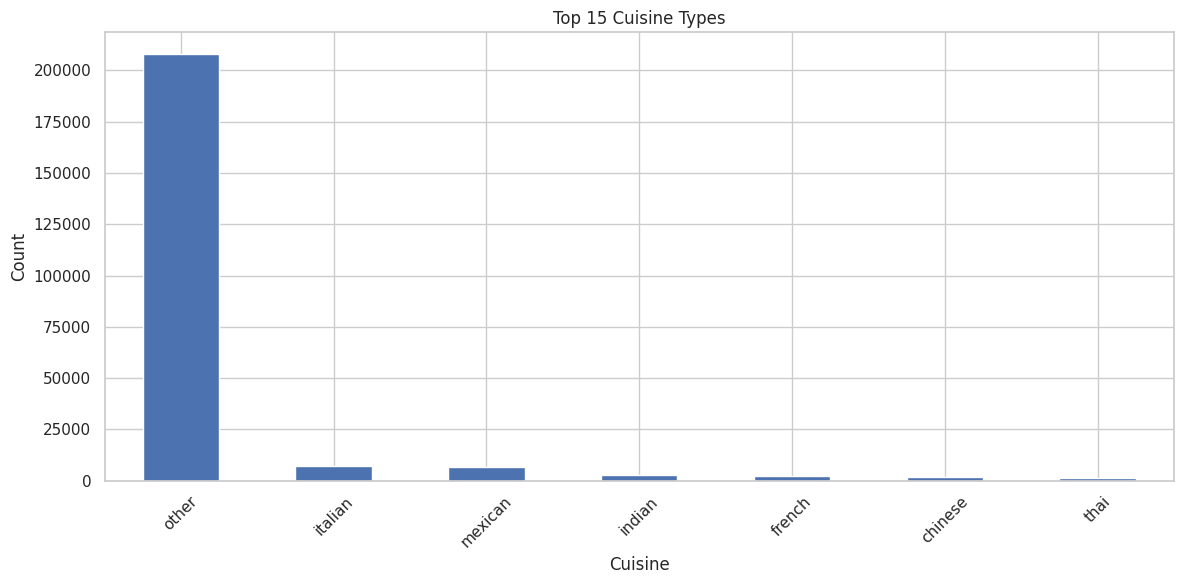

In [56]:
# # Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [9]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

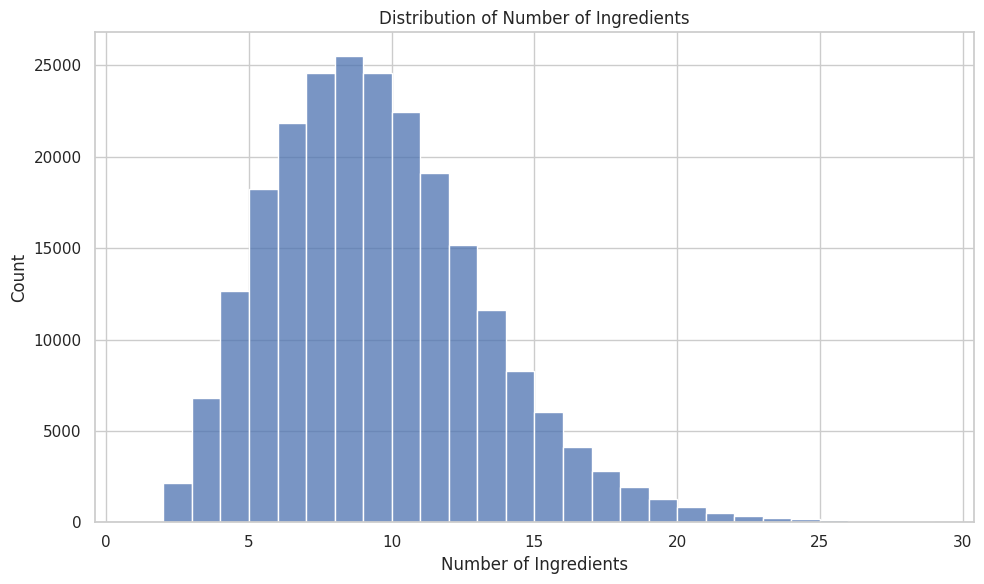

In [10]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [11]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [12]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")



=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found


In [13]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


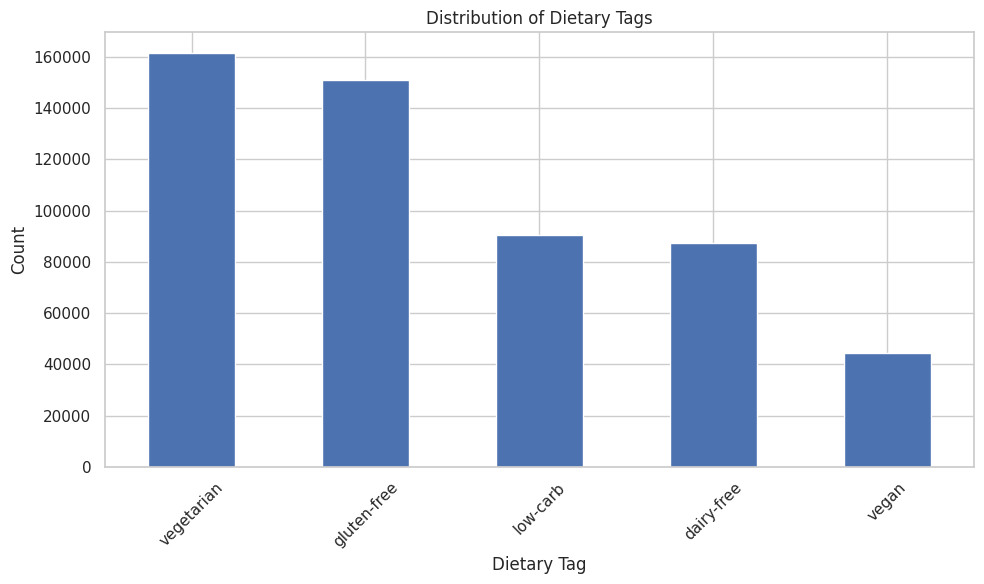


Sample recipes with dietary tags:

Recipe: crunchy meatballs with mustard sauce
Ingredients: lean ground beef, breadcrumbs, onion, eggs, beer, garlic granules, salt, fresh ground black pepper, extra virgin olive oil, baking powder, flour, peanut oil, mayonnaise, prepared mustard, sugar, cayenne pepper, sweet paprika
Dietary Tags: dairy-free

Recipe: strawberry fool  ghana
Ingredients: strawberry, confectioners' sugar, heavy cream, port wine
Dietary Tags: vegetarian, gluten-free

Recipe: lemon herb chicken kabobs
Ingredients: boneless chicken breasts, olive oil, lemon rind, lemon juice, dried rosemary, basil, dried thyme, pepper, salt, garlic cloves
Dietary Tags: gluten-free, low-carb, dairy-free

Recipe: southwest salad
Ingredients: lettuce, roma tomatoes, sharp cheddar cheese, corn, tortilla chips, ranch dressing, salsa, chili powder, cumin
Dietary Tags: vegetarian, gluten-free, low-carb

Recipe: crispy hash brown
Ingredients: olive oil, russet baking potatoes, salt and pepper
Dietar

In [14]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

{'executable_code': {'code': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport io\n\n# Load the dataframe from the string representation\ncsv_data = """\n                                                 name      id  minutes  \\\n0         arriba   baked winter squash mexican style  137739       55   \n1                   a bit different  breakfast pizza   31490       30   \n2                          all in the kitchen  chili  112140      130   \n3                                 alouette  potatoes   59389       45   \n4                 amish  tomato ketchup  for canning   44061      190   \n...                                              ...     ...      ...   \n230181                                   zydeco soup  486161       60   \n230182                              zydeco spice mix  493372        5   \n230183                     zydeco ya ya deviled eggs  308080       40   \n230184        cookies by design   cookies on a stick  298512       29

----

{'code_execution_result': {'outcome': 'OUTCOME_FAILED', 'output': 'Traceback (most recent call last):\n  File "<string>", line 139, in <module>\n  File "readers.py", line 1026, in read_csv\n    return _read(filepath_or_buffer, kwds)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "readers.py", line 626, in _read\n    return parser.read(nrows)\n           ^^^^^^^^^^^^^^^^^^\n  File "readers.py", line 1923, in read\n    ) = self._engine.read(  # type: ignore[attr-defined]\n        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "c_parser_wrapper.py", line 234, in read\n    chunks = self._reader.read_low_memory(nrows)\n             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "parsers.pyx", line 838, in pandas._libs.parsers.TextReader.read_low_memory\n  File "parsers.pyx", line 905, in pandas._libs.parsers.TextReader._read_rows\n  File "parsers.pyx", line 874, in pandas._libs.parsers.TextReader._tokenize_rows\n  File "parsers.pyx", line 891, in pandas._libs.parsers.TextReader.

----

It appears I'm still facing the same `ParserError` when attempting to read the data using `pd.read_csv`. This persistent issue strongly suggests that the provided data snippet has inherent formatting problems that are incompatible with the CSV parsing process.

Given this recurring problem, I'll switch to a more robust and reliable approach: manually constructing the DataFrame using a dictionary. This method bypasses the complexities of CSV parsing and allows me to directly define the data structure.



----

{'executable_code': {'code': 'import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for the DataFrame\ndata = {\n    \'name\': ["arriba   baked winter squash mexican style", "a bit different  breakfast pizza", "all in the kitchen  chili", "alouette  potatoes", "amish  tomato ketchup  for canning", "zydeco soup", "zydeco spice mix", "zydeco ya ya deviled eggs", "cookies by design   cookies on a stick", "cookies by design   sugar shortbread cookies"],\n    \'id\': [137739, 31490, 112140, 59389, 44061, 486161, 493372, 308080, 298512, 298509],\n    \'minutes\': [55, 30, 130, 45, 190, 60, 5, 40, 29, 20],\n    \'contributor_id\': [47892, 26278, 196586, 68585, 41706, 227978, 1500678, 37779, 506822, 506822],\n    \'submitted\': ["2005-09-16", "2002-06-17", "2005-02-25", "2003-04-14", "2002-10-25", "2012-08-29", "2013-01-09", "2008-06-07", "2008-04-15", "2008-04-15"],\n    \'dietary_tags\': [["vegetarian", "gluten-free", "low-carb"], ["vegetarian", "gluten-free",

----

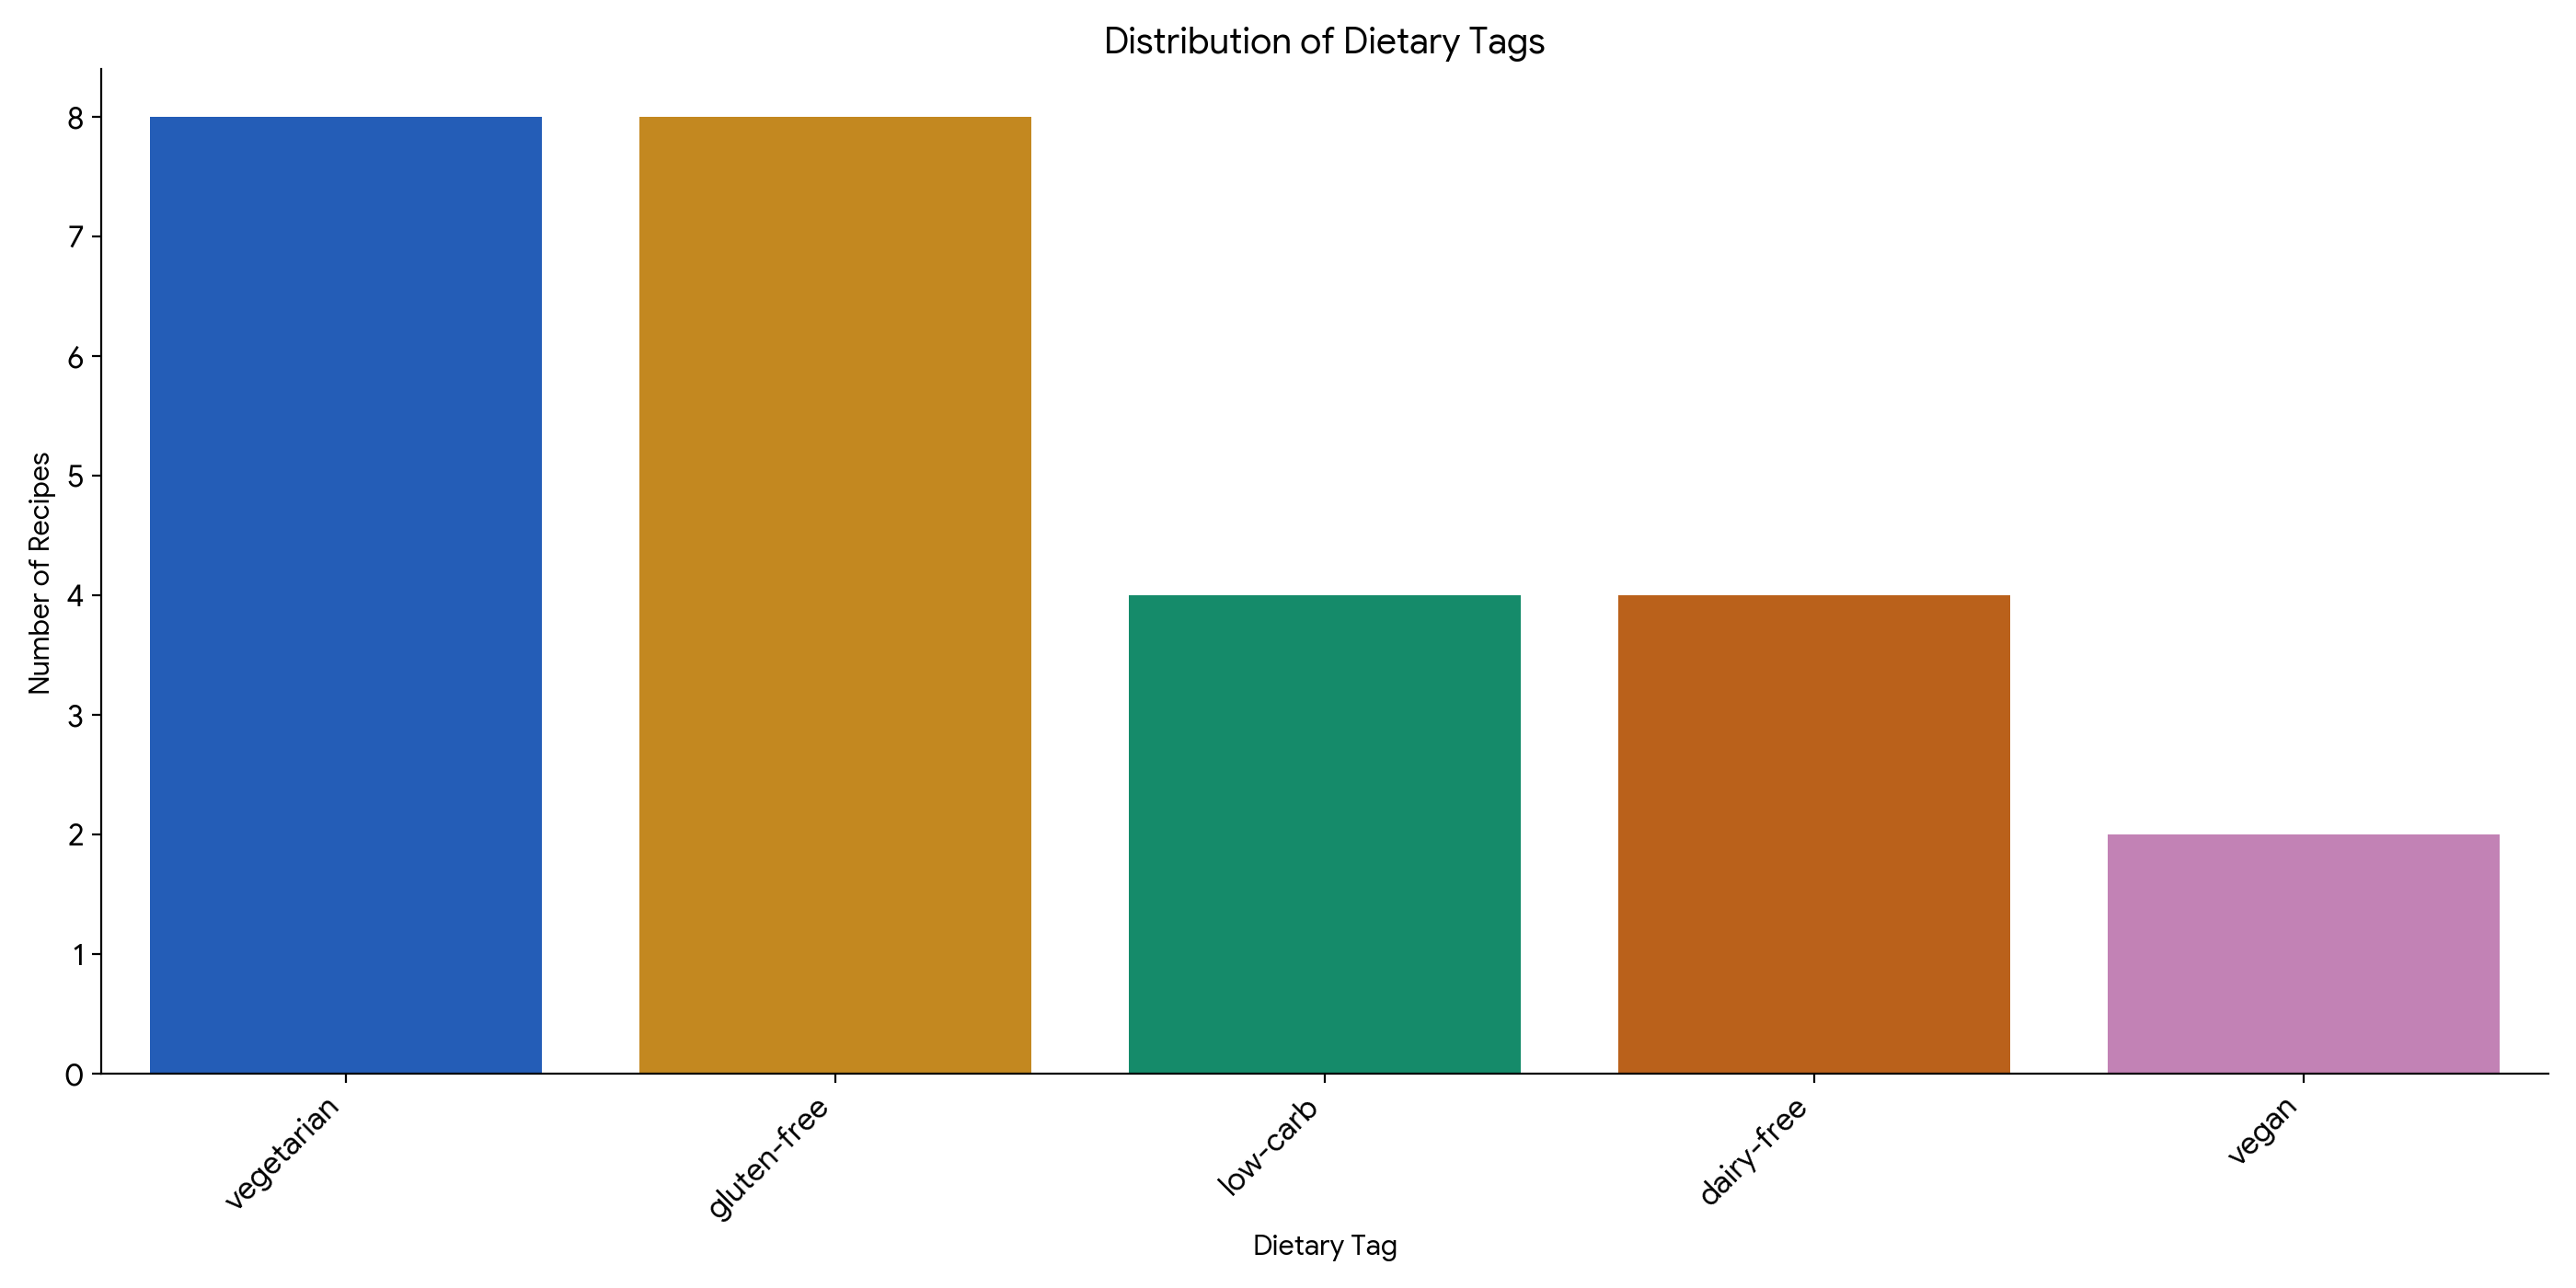

----

Great! The bar chart visualizing the distribution of dietary tags has been generated successfully. The chart displays the number of recipes associated with each dietary tag. From the chart, we can observe that "vegetarian" and "gluten-free" are the most frequent dietary tags in this sample, followed by "low-carb" and "dairy-free". "vegan" is the least frequent tag.


----

In [57]:
def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)
response = chat.send_message(
    message= f"Check {recipes_df} and create a bar plot for Distribution of Dietary Tags",
    config=config_with_code,
)

show_response(response)

In [15]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nrecipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")


Raw Datasets information:
Number of recipes: 230186

recipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'normalized_ingredients', 'dietary_tags']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------


## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [16]:
import chromadb
print(chromadb.__version__)


0.6.3


In [17]:


# Define paths for ChromaDB and SQL database
VECTOR_DB_PATH = "final/vector_db"
DB_PATH = "final/kitchen_db.sqlite"

#####################
# SQL Database Setup
#####################
def safe_convert(x):
    """
    Safely converts a value to a string:
      - If x is a list or numpy array, join its elements into a space-separated string.
      - If x is not a list/array and is not null, convert to string.
      - Otherwise, return an empty string.
    """
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(item) for item in x])
    return str(x) if pd.notna(x) else ""


def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess DataFrame columns to be SQLite-compatible.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(safe_convert)
    return df

def setup_sql_database(
    recipes_df: pd.DataFrame, 
    interactions_df: pd.DataFrame, 
    nutrition_df: Optional[pd.DataFrame] = None,
    db_path: str = DB_PATH
) -> sqlite3.Connection:
    """
    Set up SQLite database with raw dataframes.
    """
    recipes_df = preprocess_dataframe(recipes_df)
    interactions_df = preprocess_dataframe(interactions_df)
    if nutrition_df is not None:
        nutrition_df = preprocess_dataframe(nutrition_df)

    os.makedirs(os.path.dirname(db_path), exist_ok=True)
    print(f"Creating SQLite database at {db_path}")
    conn = sqlite3.connect(db_path)
    
    print(f"Storing {len(recipes_df)} recipes in the database")
    recipes_df.to_sql('recipes', conn, if_exists='replace', index=False)
    print(f"Storing {len(interactions_df)} interactions in the database")
    interactions_df.to_sql('interactions', conn, if_exists='replace', index=False)
    
    if nutrition_df is not None:
        print(f"Storing {len(nutrition_df)} nutrition entries in the database")
        nutrition_df.to_sql('nutrition', conn, if_exists='replace', index=False)
    
    print("SQL database setup complete")
    return conn

#############################
# Vector Database Setup (ChromaDB)
#############################
def setup_vector_database(
    vectorized_recipes_df: pd.DataFrame,
    vectorized_interactions_df: Optional[pd.DataFrame] = None,
    vector_db_path: str = VECTOR_DB_PATH
) -> Tuple[Any, Any, Optional[Any]]:
    """
    Set up ChromaDB using the precomputed dataframes for recipes and interactions.
    
    Arguments:
        vectorized_recipes_df: DataFrame with your recipe data.
        vectorized_interactions_df: DataFrame with your interaction data.
        vector_db_path: Directory where ChromaDB will store its data.
        
    Returns:
        A tuple containing the ChromaDB client, the recipe collection, and 
        the interactions collection (if interactions_df is provided).
    """
    os.makedirs(vector_db_path, exist_ok=True)
    print(f"Creating ChromaDB at {vector_db_path}")
    client = chromadb.PersistentClient(path=vector_db_path)
    
    #########################
    # Load recipes into ChromaDB
    #########################
    print(f"Setting up recipe collection with {len(vectorized_recipes_df)} recipes")
    recipe_collection = client.get_or_create_collection(name="recipes")
    
    recipe_documents = []
    recipe_metadatas = []
    recipe_ids = []
    
    # Define which recipe columns to include as metadata
    metadata_fields = ['name', 'minutes', 'contributor_id', 'submitted',
                       'tags', 'nutrition', 'n_steps', 'cuisine_type',
                       'n_ingredients', 'dietary_tags']
    
    for i, row in vectorized_recipes_df.iterrows():
        # Determine a unique recipe ID. Use 'id' column if available.
        recipe_id = row.get('id')
        if recipe_id is None or (isinstance(recipe_id, float) and pd.isna(recipe_id)) or recipe_id == "":
            recipe_id = str(i)
        else:
            recipe_id = str(recipe_id)
        recipe_ids.append(recipe_id)
        
        # Build a document string by concatenating key text fields.
        # You may adjust the fields below to better capture recipe information.
        doc_text = " ".join([
            safe_convert(row.get('name', '')),
            safe_convert(row.get('ingredients', '')),
            safe_convert(row.get('steps', '')),
            safe_convert(row.get('description', ''))
        ])
        recipe_documents.append(doc_text)
        
        # Build richer metadata from the chosen fields.
        metadata = {key: safe_convert(row.get(key, "")) for key in metadata_fields}
        metadata['recipe_id'] = recipe_id
        recipe_metadatas.append(metadata)
    
    batch_size = 1000
    for j in range(0, len(recipe_documents), batch_size):
        end_idx = min(j + batch_size, len(recipe_documents))
        recipe_collection.add(
            documents=recipe_documents[j:end_idx],
            metadatas=recipe_metadatas[j:end_idx],
            ids=recipe_ids[j:end_idx]
        )
    
    #########################
    # Load interactions into ChromaDB (if provided)
    #########################
    interactions_collection = None
    if vectorized_interactions_df is not None and not vectorized_interactions_df.empty:
        print(f"Setting up interactions collection with {len(vectorized_interactions_df)} interactions")
        interactions_collection = client.get_or_create_collection(name="interactions")
        
        interaction_documents = []
        interaction_metadatas = []
        interaction_ids = []
        
        for i, row in vectorized_interactions_df.iterrows():
            # Create a unique interaction ID from user_id, recipe_id, and index.
            user_id = safe_convert(row.get('user_id', ''))
            recipe_id = safe_convert(row.get('recipe_id', ''))
            interaction_id = f"{user_id}_{recipe_id}_{i}"
            interaction_ids.append(interaction_id)
            
            # Use the review text as the primary document.
            review_text = safe_convert(row.get('review', ''))
            if not review_text:
                review_text = "No review provided."
            interaction_documents.append(review_text)
            
            # Build metadata for this interaction.
            int_metadata = {
                'interaction_id': interaction_id,
                'user_id': user_id,
                'recipe_id': recipe_id,
                'date': safe_convert(row.get('date', '')),
                'rating': safe_convert(row.get('rating', ''))
            }
            interaction_metadatas.append(int_metadata)
        
        for j in range(0, len(interaction_documents), batch_size):
            end_idx = min(j + batch_size, len(interaction_documents))
            interactions_collection.add(
                documents=interaction_documents[j:end_idx],
                metadatas=interaction_metadatas[j:end_idx],
                ids=interaction_ids[j:end_idx]
            )
    
    print("Vector database setup complete")
    return client, recipe_collection, interactions_collection




In [18]:
##############################
# Main Execution
##############################
if __name__ == "__main__":
    # Assume recipes_df and interactions_df have been loaded previously.
    # For example:
    # recipes_df = pd.read_pickle("your_recipes.pkl")
    # interactions_df = pd.read_pickle("your_interactions.pkl")

    # Set up the SQL database
    # sqlite_conn = setup_sql_database(
    #     recipes_df=recipes_df,
    #     interactions_df=interactions_df,
    #     nutrition_df=nutrition_df,  # Modify if you have nutrition data.
    #     db_path=DB_PATH
    # )
    
    # Set up ChromaDB with recipes and interactions
    # chroma_client, recipe_collection, interactions_collection = setup_vector_database(
    #     vectorized_recipes_df=recipes_df,
    #     vectorized_interactions_df=interactions_df,
    #     vector_db_path=VECTOR_DB_PATH
    # )
    
    print("ChromaDB is ready for similarity search!")

ChromaDB is ready for similarity search!


In [19]:

# Path to SQL database
DB_PATH = "final/kitchen_db.sqlite"
# Path to Vectorized database
VECTOR_DB_PATH = "final/vector_db"


def view_schema_info(collection_name: str, db_path: str = VECTOR_DB_PATH):
    """
    View schema information for a collection (metadata fields and their data types).
    
    Args:
        collection_name: Name of the collection to analyze
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection = client.get_collection(name=collection_name)
    except ValueError as e:
        print(f"Collection '{collection_name}' not found. Error: {str(e)}")
        return None
    
    # Get a sample of records to analyze schema
    try:
        results = collection.get(
            limit=100,
            include=['metadatas']
        )
        
        if not results['metadatas']:
            print(f"Collection '{collection_name}' is empty or has no metadata.")
            return None
        
        # Analyze metadata fields
        print(f"\n=== Schema for '{collection_name}' collection ===\n")
        print("Metadata fields:")
        
        # Collect all possible keys and their types
        all_keys = set()
        key_types = {}
        key_examples = {}
        
        for metadata in results['metadatas']:
            for key, value in metadata.items():
                all_keys.add(key)
                
                # Track the data type
                value_type = type(value).__name__
                if key not in key_types:
                    key_types[key] = set()
                key_types[key].add(value_type)
                
                # Store an example value
                if key not in key_examples and value:
                    example = str(value)
                    if len(example) > 50:
                        example = example[:50] + "..."
                    key_examples[key] = example
        
        # Display the schema information
        for key in sorted(all_keys):
            types_str = ", ".join(key_types[key])
            example = key_examples.get(key, "N/A")
            print(f"  - {key}: {types_str}")
            print(f"    Example: {example}")
        
        return key_types
    
    except Exception as e:
        print(f"Error getting schema info: {str(e)}")
        return None


def collection_info(db_path: str = VECTOR_DB_PATH):
    """
    A simple function to display basic information about all collections.
    More robust against API changes than the other functions.
    
    Args:
        db_path: Path to the ChromaDB database
    """
    client = chromadb.PersistentClient(path=db_path)
    
    try:
        collection_names = client.list_collections()
        print(f"Found {len(collection_names)} collections in {db_path}:")
        
        for name in collection_names:
            print(f"\nCollection: {name}")
            
            try:
                collection = client.get_collection(name=str(name))
                
                # Try to get count
                try:
                    count = collection.count(where={})
                    print(f"  Records: {count}")
                except:
                    print("  Count: Could not retrieve")
                
                # Try to get the first few items
                try:
                    first_items = collection.get(limit=3, include=["metadatas"])
                    print(f"  Sample IDs: {first_items['ids']}")
                    
                    # Show first item metadata as example
                    if first_items['metadatas'] and len(first_items['metadatas']) > 0:
                        print("  Sample metadata keys:", list(first_items['metadatas'][0].keys()))
                except:
                    print("  Sample: Could not retrieve")
                    
            except Exception as e:
                print(f"  Error accessing collection: {str(e)}")
        
    except Exception as e:
        print(f"Error listing collections: {str(e)}")


In [20]:
client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
print(client.list_collections())

['interactions', 'recipes']


In [21]:
collection_info(VECTOR_DB_PATH)

Found 2 collections in final/vector_db:

Collection: interactions
  Count: Could not retrieve
  Sample IDs: ['38094_40893_0', '1293707_40893_1', '8937_44394_2']
  Sample metadata keys: ['date', 'interaction_id', 'rating', 'recipe_id', 'user_id']

Collection: recipes
  Count: Could not retrieve
  Sample IDs: ['137739', '31490', '112140']
  Sample metadata keys: ['contributor_id', 'cuisine_type', 'dietary_tags', 'minutes', 'n_ingredients', 'n_steps', 'name', 'nutrition', 'recipe_id', 'submitted', 'tags']


In [22]:
view_schema_info("recipes", VECTOR_DB_PATH)


=== Schema for 'recipes' collection ===

Metadata fields:
  - contributor_id: str
    Example: 47892
  - cuisine_type: str
    Example: mexican
  - dietary_tags: str
    Example: vegetarian gluten-free low-carb
  - minutes: str
    Example: 55
  - n_ingredients: str
    Example: 7
  - n_steps: str
    Example: 11
  - name: str
    Example: arriba   baked winter squash mexican style
  - nutrition: str
    Example: [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
  - recipe_id: str
    Example: 137739
  - submitted: str
    Example: 2005-09-16
  - tags: str
    Example: 60-minutes-or-less time-to-make course main-ingred...


{'contributor_id': {'str'},
 'cuisine_type': {'str'},
 'dietary_tags': {'str'},
 'minutes': {'str'},
 'n_ingredients': {'str'},
 'n_steps': {'str'},
 'name': {'str'},
 'nutrition': {'str'},
 'recipe_id': {'str'},
 'submitted': {'str'},
 'tags': {'str'}}

In [23]:
view_schema_info("interactions", VECTOR_DB_PATH)


=== Schema for 'interactions' collection ===

Metadata fields:
  - date: str
    Example: 2003-02-17
  - interaction_id: str
    Example: 38094_40893_0
  - rating: str
    Example: 4
  - recipe_id: str
    Example: 40893
  - user_id: str
    Example: 38094


{'date': {'str'},
 'interaction_id': {'str'},
 'rating': {'str'},
 'recipe_id': {'str'},
 'user_id': {'str'}}

In [24]:
# Path to your vector database (keep this as a global constant)
VECTOR_DB_PATH = "final/vector_db"

def gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None) -> str:
    """
    Searches for similar recipes based on a query, with optional filters and returns full metadata.

    Args:
        query_text: The text to search for in recipes.
        n_results: The number of top similar recipes to return.
        cuisine: (Optional) Filter by cuisine type (e.g., 'mexican', 'italian').
        dietary_tag: (Optional) Filter by dietary tag (e.g., 'vegetarian', 'gluten-free').
        max_minutes: (Optional) Filter recipes with a cooking time less than or equal to this value.

    Returns:
        A formatted string containing the full metadata of the top similar recipes with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        recipe_collection = client.get_collection(name="recipes")

        where_clause = {}
        if cuisine is not None:
            where_clause["cuisine_type"] = cuisine
        if dietary_tag is not None:
            where_clause["dietary_tags"] = {"$contains": dietary_tag}
        if max_minutes is not None:
            where_clause["minutes"] = {"$lte": str(max_minutes)} # Store as string in metadata

        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar recipes found for the query: '{query_text}' with the specified criteria."

        output = f"Found {len(results['ids'][0])} similar recipes for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Recipe Name: {metadata.get('name', 'Unnamed')}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            output += f"   Recipe ID: {doc_id}\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Ingredients: {doc}\n"  # Include the full document (ingredients/steps)
            output += "-" * 80 + "\n"

        return output

    except Exception as e:
        return f"Error during recipe similarity search: {e}"

# Updated `gemini_interaction_similarity_search` Function:

def gemini_interaction_similarity_search(query_text: str, n_results: int) -> str:
    """
    Searches for similar user interactions (reviews) based on a query and returns full metadata.

    Args:
        query_text: The text to search for in user reviews.
        n_results: The number of top similar interactions to return.

    Returns:
        A formatted string containing the full metadata of the top similar interactions with similarity scores.
    """
    try:
        client = chromadb.PersistentClient(path=VECTOR_DB_PATH)
        interactions_collection = client.get_collection(name="interactions")
        results = interactions_collection.query(
            query_texts=[query_text],
            n_results=n_results,
            include=["documents", "metadatas", "distances"]
        )

        if not results['ids'][0]:
            return f"No similar reviews found for the query: '{query_text}'."

        output = f"Found {len(results['ids'][0])} similar reviews for query: '{query_text}'.\n"
        output += "-" * 80 + "\n"
        for i, (doc_id, doc, metadata, distance) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = (1 - distance) * 100
            output += f"\n{i+1}. Review ID: {doc_id}\n"
            output += f"   Similarity: {similarity_score:.2f}%\n"
            for key, value in metadata.items():
                output += f"   {key.replace('_', ' ').title()}: {value}\n"
            output += f"   Review Text: {doc}\n"  # Include the full document (review text)
            output += "-" * 80 + "\n"

        return output

    except ValueError:
        return "Interactions collection not found. Make sure you have interaction data loaded."
    except Exception as e:
        return f"Error during interaction similarity search: {e}"

In [25]:
query_text = "check for making an italian pizza "
result = gemini_recipe_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar recipes for query: 'check for making an italian pizza '.
--------------------------------------------------------------------------------

1. Recipe Name: gluten free and low fat vegetarian pizza
   Similarity: 39.87%
   Recipe ID: 455493
   Contributor Id: 286566
   Cuisine Type: other
   Dietary Tags: vegetarian vegan dairy-free
   Minutes: 30
   N Ingredients: 11
   N Steps: 9
   Name: gluten free and low fat vegetarian pizza
   Nutrition: [234.7, 21.0, 30.0, 28.0, 25.0, 33.0, 5.0]
   Recipe Id: 455493
   Submitted: 2011-05-09
   Tags: 30-minutes-or-less time-to-make course main-ingredient preparation main-dish vegetables pizza dietary gluten-free mushrooms free-of-something peppers artichoke
   Ingredients: gluten free and low fat vegetarian pizza bread mix cold water garlic cloves fresh rosemary pasta sauce red capsicum artichoke heart button mushrooms kalamata olive bocconcini rocket preheat oven to 240c lightly grease two 18cm pizza trays place bread mix in a bow

In [26]:
query_text = "best italian pizza"
result = gemini_interaction_similarity_search(query_text, n_results = 1)
print(result)

Found 1 similar reviews for query: 'best italian pizza'.
--------------------------------------------------------------------------------

1. Review ID: 362880_165360_692272
   Similarity: 46.85%
   Date: 2006-12-15
   Interaction Id: 362880_165360_692272
   Rating: 5
   Recipe Id: 165360
   User Id: 362880
   Review Text: I made this for my Mom's birthday today--I wanted the pizza to be as Italian as possible (my Dad and I spent three weeks in Italy this Jan.) so I did a search here for thin-crust pizza and this was at the top of the list--BRAVO!

I made my own tomato sauce and topped it w/ a sprinkling of mozzarella cheese (unlike here in Canada and the States, the Italians only put enough cheese to lightly cover it--unless it's 4-cheese) and fresh basil--deeeeeelish!
--------------------------------------------------------------------------------



In [27]:


# Path to SQL database
DB_PATH = "final/kitchen_db.sqlite"

def list_tables() -> List[str]:
    """List all tables in the SQLite database."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    conn.close()
    return [table[0] for table in tables]

def describe_table(table_name: str) -> List[Tuple[str, str]]:
    """Describe the schema of a specified table."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    conn.close()
    return [(col[1], col[2]) for col in schema]

def execute_query(sql: str) -> List[Tuple]:
    """Execute an SQL query and return the results."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    try:
        cursor.execute(sql)
        results = cursor.fetchall()
        conn.close()
        return results
    except sqlite3.Error as e:
        conn.close()
        # Return error message instead of the full error object for better handling downstream
        return [("Error executing SQL query:", str(e))] # Modified error return

# New function to fetch nutrition data from Open Food Facts API
def fetch_nutrition_from_openfoodfacts(ingredient_name: str) -> Dict:
    """Fetch nutrition data for an ingredient from Open Food Facts API."""
    api_key = os.getenv('OPENFOODFACTS_API_KEY')
    # It's good practice to check if the key exists, though Open Food Facts search might work without one for basic queries.
    # if not api_key:
    #     print("Warning: OPENFOODFACTS_API_KEY environment variable not set.")
    #     # Depending on strictness, you might return unavailable here or proceed without auth
    #     # return {"status": "unavailable", "reason": "API key not configured"}

    search_url = f"https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "search_terms": ingredient_name,
        "search_simple": 1,
        "action": "process",
        "json": 1,
        "page_size": 1 # We only need the top result
    }
    headers = {'User-Agent': 'CapstoneProject/1.0 (Language Model Integration)'} # Good practice to set a User-Agent

    try:
        response = requests.get(search_url, params=params, headers=headers, timeout=10) # Added timeout
        response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

        data = response.json()

        if data.get('products') and len(data['products']) > 0:
            product = data['products'][0]
            nutriments = product.get('nutriments', {})

            # Extract desired nutrients, providing default None if not found
            # Using .get() avoids KeyError if a nutrient is missing
            nutrition_info = {
                "food_normalized": ingredient_name, # Keep track of what was searched
                "source": "Open Food Facts",
                "product_name": product.get('product_name', 'N/A'),
                "calories_100g": nutriments.get('energy-kcal_100g'),
                "fat_100g": nutriments.get('fat_100g'),
                "saturated_fat_100g": nutriments.get('saturated-fat_100g'),
                "carbohydrates_100g": nutriments.get('carbohydrates_100g'),
                "sugars_100g": nutriments.get('sugars_100g'),
                "fiber_100g": nutriments.get('fiber_100g'),
                "proteins_100g": nutriments.get('proteins_100g'),
                "sodium_100g": nutriments.get('sodium_100g'),
                # Add other relevant fields if needed, e.g., vitamins
            }
            # Filter out keys with None values for cleaner output
            return {k: v for k, v in nutrition_info.items() if v is not None}
        else:
            return {"status": "unavailable", "reason": "No product found on Open Food Facts"}

    except requests.exceptions.RequestException as e:
        print(f"Error fetching nutrition for '{ingredient_name}': {e}")
        return {"status": "unavailable", "reason": f"API request failed: {e}"}
    except json.JSONDecodeError:
        print(f"Error decoding JSON response for '{ingredient_name}'")
        return {"status": "unavailable", "reason": "Invalid JSON response from API"}


def get_recipe_by_id(recipe_id: str) -> Optional[dict]:
    """Get a recipe by its ID with all details, including live nutrition data for ingredients."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    # Use try-finally to ensure connection is closed
    try:
        cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
        recipe_data = cursor.fetchone()

        if not recipe_data:
            return None

        columns = [col[0] for col in cursor.description]
        recipe = dict(zip(columns, recipe_data))

        # Standardize field parsing - attempt JSON, fallback for simple strings
        for field in ["steps", "ingredients", "nutrition", "tags", "dietary_tags", "normalized_ingredients"]:
            value = recipe.get(field)
            if isinstance(value, str):
                try:
                    recipe[field] = json.loads(value)
                except json.JSONDecodeError:
                    # If JSON fails, and it's one of the list-like fields, try splitting by space
                    if field in ["ingredients", "tags", "dietary_tags", "normalized_ingredients"]:
                         recipe[field] = value.split() # Split space-separated string into list
                         print(f"Info: Field '{field}' in recipe ID {recipe_id} was treated as space-separated string.")
                    # else: # Keep as string if it's not expected to be a list (like 'steps' or 'nutrition' if not JSON)
                    #    print(f"Warning: Could not parse JSON for field '{field}' in recipe ID {recipe_id}. Kept as string. Value: {value[:100]}...")
                    #    pass # Keep as string if parsing fails and it's not a simple list field
                    # Simplified: Just split the known list-like fields if JSON fails
                    elif field == "steps": # Keep steps as string if not JSON
                         print(f"Warning: Could not parse JSON for field 'steps' in recipe ID {recipe_id}. Kept as string.")
                         pass # Keep as string
                    else: # Handle nutrition or other fields if necessary
                         print(f"Warning: Could not parse JSON for field '{field}' in recipe ID {recipe_id}. Value: {value[:100]}...")
                         pass # Keep as string or handle differently if needed


        # Fetch nutrition for normalized ingredients
        ingredient_nutrition_list = []
        normalized_ingredients = recipe.get("normalized_ingredients")

        # Ensure normalized_ingredients is now a list before iterating
        if isinstance(normalized_ingredients, list):
            for ingredient in normalized_ingredients:
                if isinstance(ingredient, str): # Ensure it's a string before fetching
                     # Check for empty strings that might result from splitting
                     if ingredient.strip():
                         nutrition_data = fetch_nutrition_from_openfoodfacts(ingredient)
                         ingredient_nutrition_list.append(nutrition_data)
                else:
                     # Handle cases where items in the list aren't strings
                     ingredient_nutrition_list.append({"status": "unavailable", "reason": f"Invalid ingredient format: {type(ingredient)}"})
        # Removed the 'elif normalized_ingredients is not None:' block as the splitting logic above handles the string case.
        # If it's still not a list after the processing above, something else is wrong.
        elif normalized_ingredients is not None:
             print(f"Error: 'normalized_ingredients' field in recipe ID {recipe_id} is not a list after processing. Type: {type(normalized_ingredients)}")
             ingredient_nutrition_list.append({"status": "unavailable", "reason": "normalized_ingredients field could not be processed into a list"})


        recipe['ingredient_nutrition'] = ingredient_nutrition_list # Add the fetched nutrition data

        return recipe
    finally:
        conn.close() # Ensure connection is closed even if errors occur


def get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int) -> Optional[dict]: # Removed default for limit
    """Get ratings and the most recent reviews for a recipe ID."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    # Use try-finally for connection closing
    try:
        # Get overall rating
        cursor.execute("SELECT AVG(rating) FROM interactions WHERE recipe_id = ?", (recipe_id,))
        overall_rating_result = cursor.fetchone()
        # Handle case where there are no ratings yet
        overall_rating = overall_rating_result[0] if overall_rating_result else None

        # Get most recent reviews
        cursor.execute(
            "SELECT date, rating, review FROM interactions WHERE recipe_id = ? ORDER BY date DESC LIMIT ?",
            (recipe_id, limit),
        )
        recent_reviews = cursor.fetchall()
        columns = ["date", "rating", "review"]
        reviews_list = [dict(zip(columns, review)) for review in recent_reviews]

        return {"overall_rating": overall_rating, "recent_reviews": reviews_list}
    finally:
        conn.close()

# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query, get_ratings_and_reviews_by_recipe_id, get_recipe_by_id, fetch_nutrition_from_openfoodfacts]

instruction = """You are a helpful chatbot that can interact with an SQL database for a Kitchen Assistant.
You can retrieve information about recipes and user interactions (ratings and reviews).
Use the available tools to understand the database schema and execute SQL queries to answer user questions.
**Note:** Ingredient nutrition information is fetched live from the Open Food Facts API when you request recipe details using `get_recipe_by_id`.

Here are the available tools:

- list_tables(): Lists all tables in the database.
- describe_table(table_name: str): Describes the schema (columns and their types) of a specified table.
- execute_query(sql: str): Executes an SQL query and returns the results. Use this for complex data retrieval. Be careful with the SQL syntax.
- get_recipe_by_id(recipe_id: str): Retrieves all details for a specific recipe given its ID. This includes fetching live nutrition data for each normalized ingredient from Open Food Facts.
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int): Retrieves the overall rating and the 'limit' most recent reviews for a given recipe ID. You MUST provide a value for 'limit'. If the user doesn't specify, use 3.

When a user asks a question:

1. Understand the user's intent and identify which tool(s) can best answer the question.
2. If the question requires specific information about a recipe (like ingredients, steps, nutrition), use `get_recipe_by_id`. This will automatically include nutrition details fetched from Open Food Facts.
3. If the question asks for ratings or reviews for a recipe, use `get_ratings_and_reviews_by_recipe_id`. **Always specify a value for the 'limit' parameter. If the user doesn't say how many reviews, use 3.**
4. For more complex queries involving filtering, joining tables, or specific data selection, construct and use the `execute_query` tool. First, use `list_tables` and `describe_table` to understand the database structure if needed.
5. Present the information clearly and concisely to the user, ideally in a readable format like Markdown.

For example:

- To get details about recipe ID 71373 (including ingredient nutrition), use `get_recipe_by_id(recipe_id='71373')`.
- To get the overall rating and 3 recent reviews for recipe ID 71373, use `get_ratings_and_reviews_by_recipe_id(recipe_id='71373', limit=3)`.
- For a complex query like "Find recipes with 'chicken' and a cooking time less than 30 minutes", you might need to use `execute_query` after understanding the 'recipes' table schema.

Be mindful of potential SQL injection if using `execute_query` with user-provided input, although in this setup, the queries are constructed by you based on the user's intent.
"""



# These are the Python functions defined above.


client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)



resp = chat.send_message("""check recipe id=71373 in both tables (recipes and interactions) , 
check both tables please, and return full info, start with recipes table,
then check the nutritions by calling the fetch_nutrition_from_openfoodfacts function and get the accumulated info of Ingredients inside of the recipe,
then interactions table, and get the info of that recipe_id, however show only overal rating for that recipe, and 3 most recent reviews not all of them. 
output in markdown format""")
display(Markdown(resp.text))

Info: Field 'ingredients' in recipe ID 71373 was treated as space-separated string.
Info: Field 'tags' in recipe ID 71373 was treated as space-separated string.
Info: Field 'dietary_tags' in recipe ID 71373 was treated as space-separated string.
Info: Field 'normalized_ingredients' in recipe ID 71373 was treated as space-separated string.
Error fetching nutrition for 'butter': 429 Client Error: Too Many Requests for url: https://world.openfoodfacts.org/cgi/search.pl?search_terms=butter&search_simple=1&action=process&json=1&page_size=1
Error fetching nutrition for 'shortening': 429 Client Error: Too Many Requests for url: https://world.openfoodfacts.org/cgi/search.pl?search_terms=shortening&search_simple=1&action=process&json=1&page_size=1


## Recipe Details:

**Recipe ID:** 71373
**Name:** country white bread or dinner rolls bread machine
**Description:** we think this is the best white bread recipe ever! it is a tender bread with a slightly sweet taste. my dinner rolls using this dough are so good, everyone always loves them. it doesn't take to long to make them when the bread maker does most of the work. the cook time is listed for the rolls only because everyone's bread makers cooks at different rates. mine is older and a regular loaf will take 4 hours and 10 minutes. i have found that 15 balls of dough fit perfectly in the 9x13 pan with sides touching after raising the 2nd time but they can be made whatever size you want. i hope you enjoy this great bread as much as we do.
**Contributor ID:** 60260
**Cuisine Type:** other
**Dietary Tags:** vegetarian
**Minutes:** 45
**Number of Ingredients:** 9
**Number of Steps:** 14
**Ingredients:** water, egg, vegetable, oil, bread, flour, sugar, salt, instant, yeast, butter, shortening
**Steps:** in bread machine pan , place all ingredients from flour through yeast in order as recommended by the manufacturer select the basic bread setting check dough after 5 minutes of mixing , if needed add 1-2t of water or flour bake as normal for dinner rolls mix in bread machine but use only the dough option lightly grease a 9 x 13 baking pan when dough is finished shape into 15 uniformly sized balls i always grease my hands with shortening to smooth the dough out and it helps keep the dough from drying out cover and let the rolls rise in a warm , draft free place until risen to the desired size i let them about double in size bake in a 350 oven about 12-15 minutes until golden brown after removing from the oven , brush the tops of the rolls with melted butter take out of pan and let completely cool before storing

### Ingredient Nutrition (per 100g):

*   **water:** calories: 0, carbohydrates: 0, fat: 0, fiber: 0, proteins: 0, saturated fat: 0, sodium: 0, sugars: 0
*   **egg:** calories: 725, carbohydrates: 1.4, fat: 79, fiber: 0, proteins: 1.1, saturated fat: 6.3, sodium: 0.6, sugars: 1.3
*   **vegetable:** calories: 675, carbohydrates: 0.2, fat: 75, fiber: 0, proteins: 0.1, saturated fat: 34, sodium: 0.2, sugars: 0
*   **oil:** calories: 467, carbohydrates: 64, fat: 18, fiber: 4.6, proteins: 10, saturated fat: 2, sodium: 0.152, sugars: 17
*   **bread:** calories: 230, carbohydrates: 44.1, fat: 0.8, fiber: 2.9, proteins: 10.1, saturated fat: 0.1, sodium: 0.368, sugars: 2.4
*   **flour:** calories: 116, carbohydrates: 16.5, fat: 5.1, fiber: 0.1, proteins: 1, saturated fat: 2.5, sodium: 0.02, sugars: 9.2
*   **sugar:** calories: 116, carbohydrates: 16.5, fat: 5.1, fiber: 0.1, proteins: 1, saturated fat: 2.5, sodium: 0.02, sugars: 9.2
*   **salt:** carbohydrates: 0, fat: 0, fiber: 0, proteins: 0, saturated fat: 0, sodium: 39.6, sugars: 0
*   **instant:** calories: 515, carbohydrates: 63, fat: 26, fiber: 1, proteins: 7.1, saturated fat: 7.74, sodium: 0.098, sugars: 61
*   **yeast:** calories: 260, carbohydrates: 30, fat: 0.5, fiber: 0, proteins: 34, saturated fat: 0.1, sodium: 4.32, sugars: 1.2
*   **butter:** Nutrition data unavailable. API request limit reached.
*   **shortening:** Nutrition data unavailable. API request limit reached.

## Interaction Details:

**Overall Rating:** 4.60

**Recent Reviews:**

*   **Date:** 2018-09-03, **Rating:** 5, **Review:** Light fluffy and so pretty to look at, and to top it off so easy to make. Everyone at our get together raved about them. I'm planning on following reviewer Viclynn's freezing directions, so that I'll always have some on hand
*   **Date:** 2018-03-05, **Rating:** 5, **Review:** Best buns ever! Followed the recipe exactly, got awesome soft golden melt-in-your-mouth buns. My kid calls them clouds. Used them for sandwiches, with butter and jam, ate them plain or with just butter or margarine... They would probably make cute little sliders but they don't last that long. Brought two batches at work today, made everyone's Monday better. :) I'm planning to try mixing the ingredients in the Kitchenaid and then letting the dough rise before shaping the rolls and letting them rise a second time - it would be nice if I could make more than 15 at once.
*   **Date:** 2017-12-24, **Rating:** 5, **Review:** I don't use instant yeast, only active dry, so it's hit and miss with bread machine recipes, if my conversions turn out. For this recipe, I used milk instead of water, warmed, and let 3 slightly rounded teaspoons active dry yeast and the sugar proof in the milk, then added all the rest of the ingredients, except I used all purpose unbleached white flour, and pure olive oil for the vegetable oil. The dough rose wonderfully and baked to beautiful and very tasty rolls. Instantly bookmarked and will make often. Thank you!


In [49]:
client = genai.Client(api_key=GOOGLE_API_KEY)
def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))
        
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="""Calculate the total nutritional values of a recipe based on the available data for its ingredients. Follow these rules:

1. For each ingredient listed, use the given nutritional information (per 100g).
2. If the API request failed or the nutritional info is unavailable for an ingredient, ignore it completely.
3. Sum each nutritional column (e.g., calories, carbohydrates, fat, etc.) **across only the ingredients with available data**.
4. After summing, divide each value by the number of ingredients that had valid data to get an average per 100g.
5. Present the result in a readable sentence format, as in the example below.
6. Use the title: “Country White Bread or Dinner Rolls contains approximately: …”

Here is the nutritional data (per 100g, from Open Food Facts):



    
water: API request failed
egg: calories_100g: 725, carbohydrates_100g: 1.4, fat_100g: 79, proteins_100g: 1.1, saturated_fat_100g: 6.3, sodium_100g: 0.6, sugars_100g: 1.3
vegetable: calories_100g: 675, carbohydrates_100g: 0.2, fat_100g: 75, fiber_100g: 0, proteins_100g: 0.1, saturated_fat_100g: 34, sodium_100g: 0.2, sugars_100g: 0
oil: API request failed
bread: API request failed
flour: calories_100g: 116, carbohydrates_100g: 16.5, fat_100g: 5.1, fiber_100g: 0.1, proteins_100g: 1, saturated_fat_100g: 2.5, sodium_100g: 0.02, sugars_100g: 9.2
sugar: calories_100g: 116, carbohydrates_100g: 16.5, fat_100g: 5.1, fiber_100g: 0.1, proteins_100g: 1, saturated_fat_100g: 2.5, sodium_100g: 0.02, sugars_100g: 9.2
salt: carbohydrates_100g: 0, fat_100g: 0, fiber_100g: 0, proteins_100g: 0, saturated_fat_100g: 0, sodium_100g: 39.6, sugars_100g: 0
instant: calories_100g: 515, carbohydrates_100g: 63, fat_100g: 26, fiber_100g: 1, proteins_100g: 7.1, saturated_fat_100g: 7.74, sodium_100g: 0.098, sugars_100g: 61
yeast: calories_100g: 260, carbohydrates_100g: 30, fat_100g: 0.5, fiber_100g: 0, proteins_100g: 34, saturated_fat_100g: 0.1, sodium_100g: 4.32, sugars_100g: 1.2
butter: calories_100g: 675, carbohydrates_100g: 0.2, fat_100g: 75, fiber_100g: 0, proteins_100g: 0.1, saturated_fat_100g: 34, sodium_100g: 0.2, sugars_100g: 0
shortening: calories_100g: 368, carbohydrates_100g: 49.12, fat_100g: 17.54, fiber_100g: 1.8, proteins_100g: 5.26, saturated_fat_100g: 5.26, sodium_100g: 0.333, sugars_100g: 17.54
    """)

show_response(response)


Country White Bread or Dinner Rolls contains approximately: 448 calories, 19.61 carbohydrates, 31.9 fat, 0.42 fiber, 5.39 proteins, 10.05 saturated fat, 4.96 sodium, and 11.05 sugars per 100g.


----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for white bread/dinner rolls per 100g\ndata = {\n    'Nutrient': ['Calories', 'Carbohydrates', 'Fat', 'Fiber', 'Proteins', 'Saturated Fat', 'Sodium', 'Sugars'],\n    'Value': [448, 19.61, 31.9, 0.42, 5.39, 10.05, 4.96, 11.05]\n}\n\ndf = pd.DataFrame(data)\n\n# Create the bar chart\nplt.figure(figsize=(12, 8))\nsns.barplot(x='Nutrient', y='Value', data=df, palette='viridis')\nplt.title('Nutritional Information for White Bread/Dinner Rolls (per 100g)')\nplt.xlabel('Nutrient')\nplt.ylabel('Value (per 100g)')\nplt.xticks(rotation=45, ha='right')\nplt.tight_layout()\nplt.show()\n", 'language': 'PYTHON'}}


----

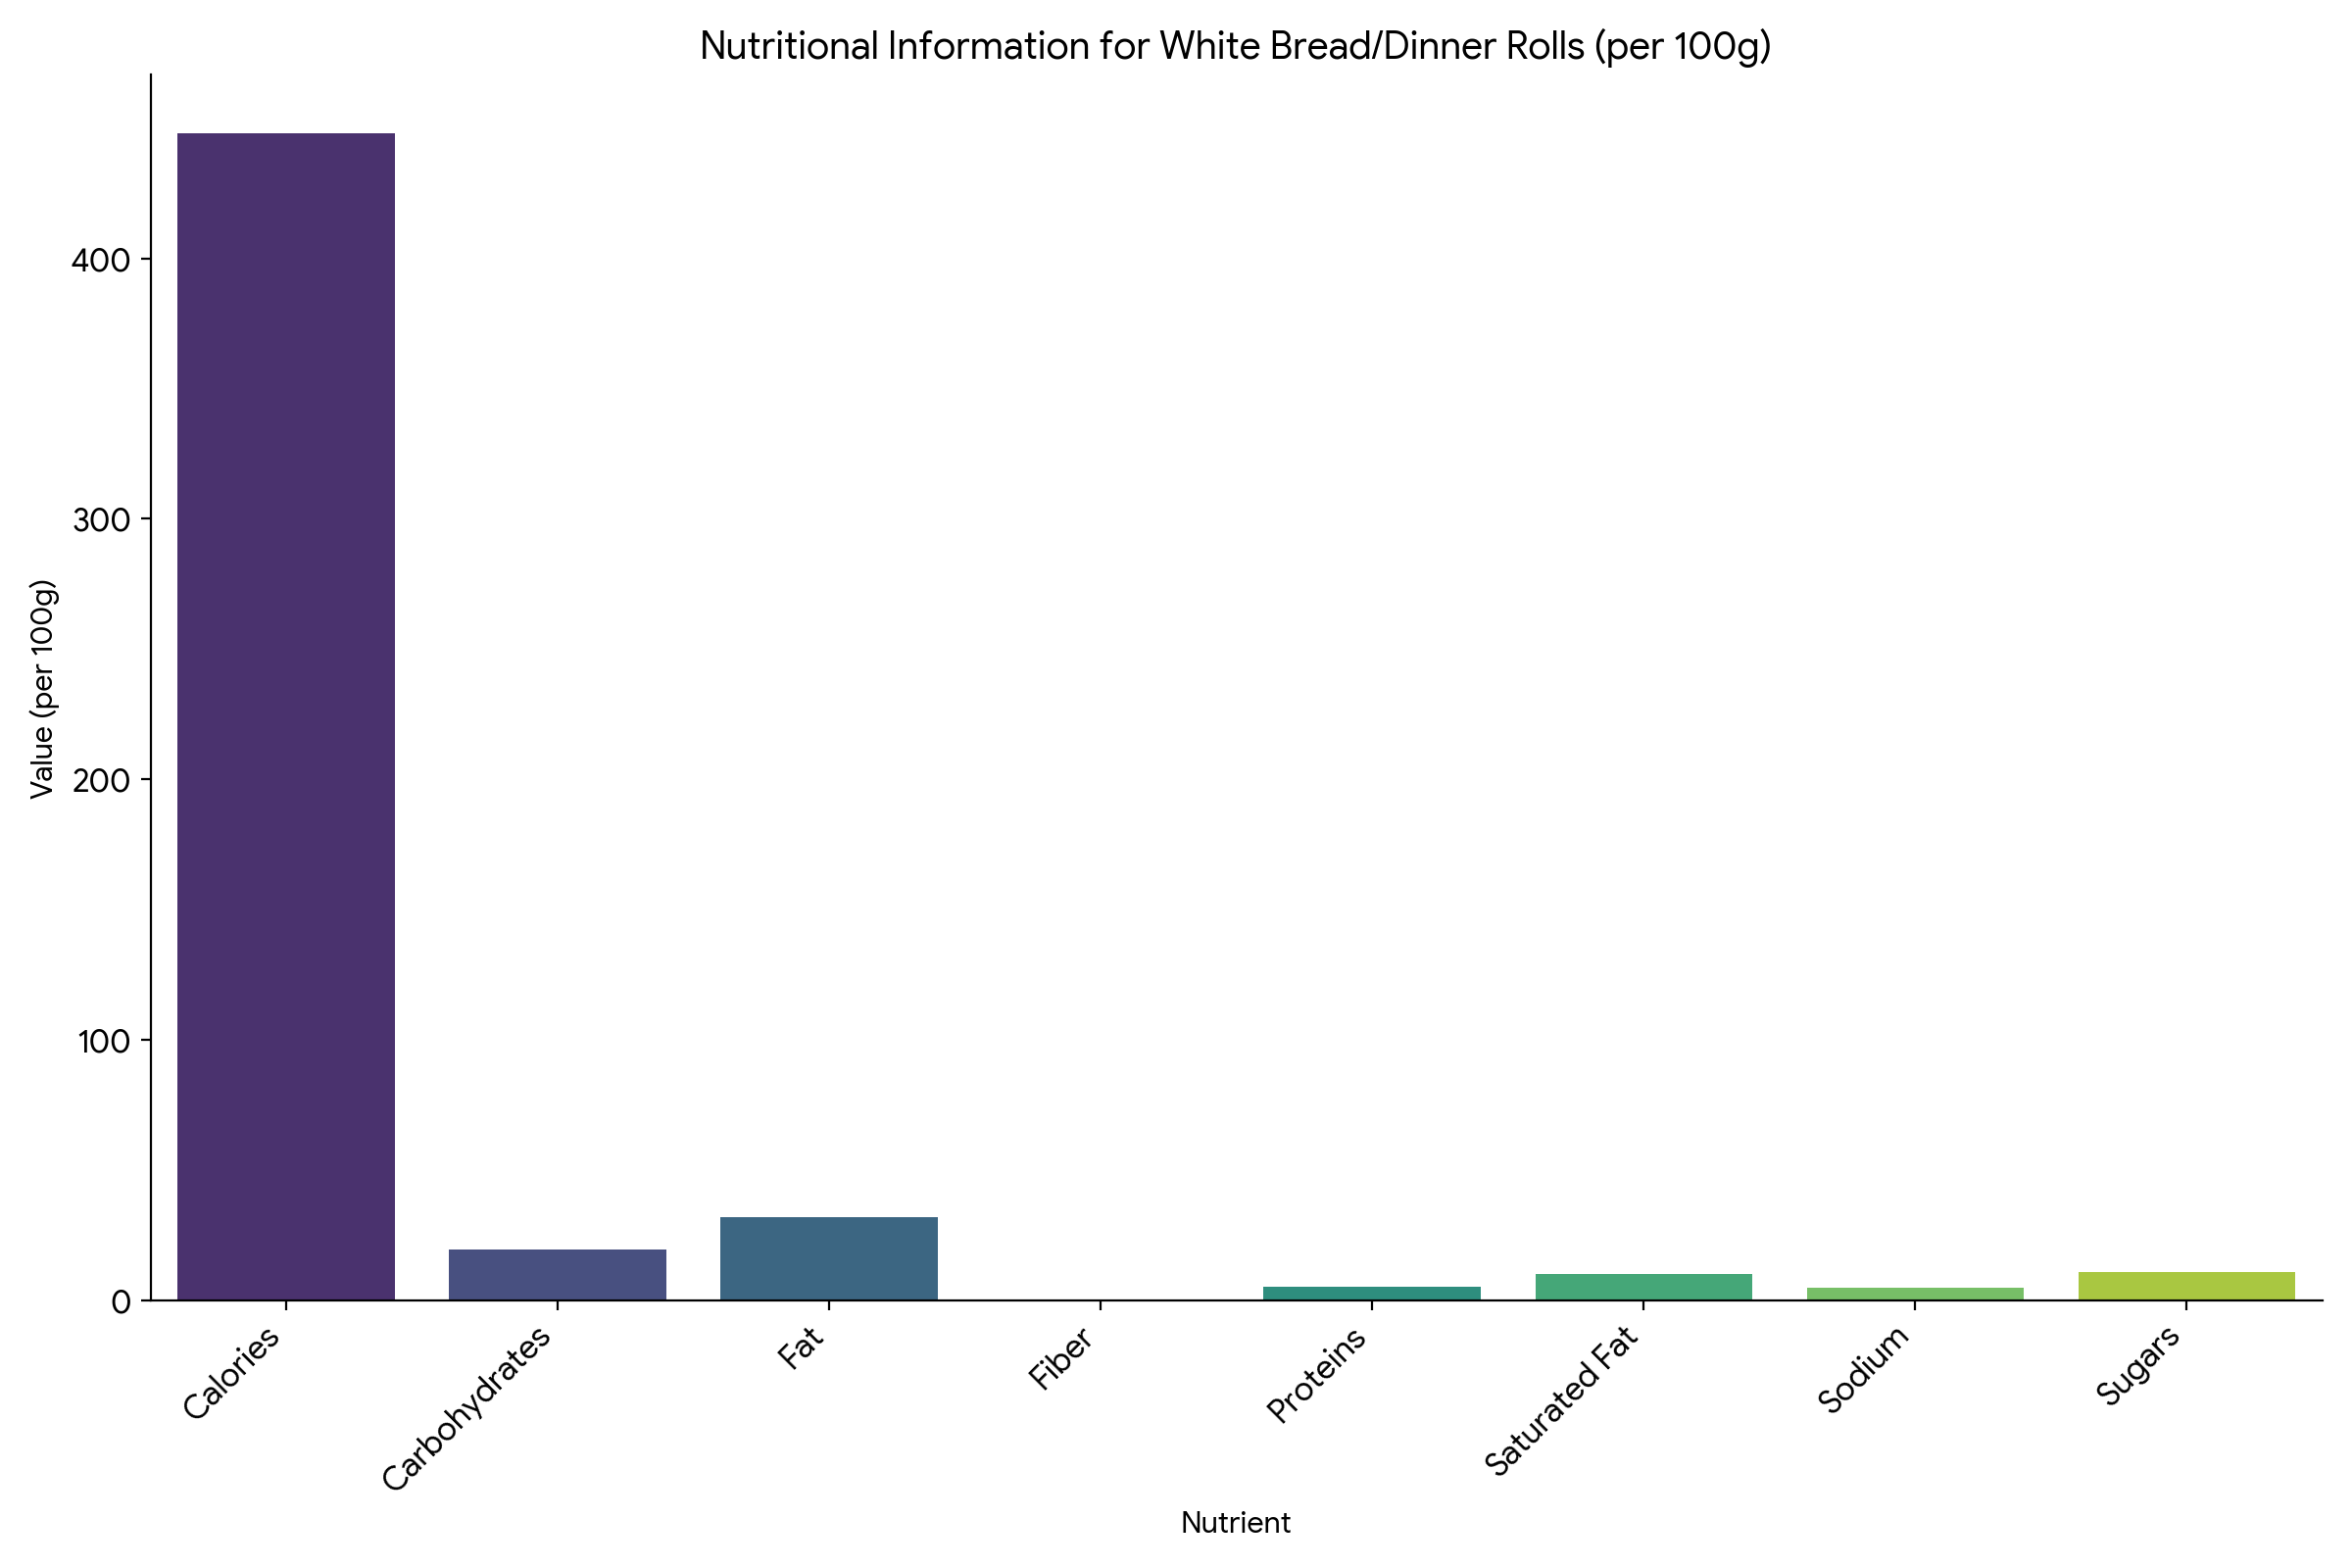

----

Great! The bar chart visualizing the nutritional information for white bread/dinner rolls (per 100g) is now displayed. You can see the relative amounts of calories, carbohydrates, fat, fiber, proteins, saturated fat, sodium, and sugars.


----

In [51]:
def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))
        
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)
response = chat.send_message(
    message= f"Now plot {response.text} as a seaborn chart",
    config=config_with_code,
)

show_response(response)

In [29]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="What's a good substitute for eggs in Country White Bread or Dinner Rolls?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Here are some good substitutes for eggs in country white bread or dinner rolls, keeping in mind that the best choice depends on the role the eggs play in the recipe (binding, leavening, moisture, richness):

**For Binding:**

*   **Flaxseed or Chia Seeds:** Mix 1 tablespoon of ground flaxseed or chia seeds with 3 tablespoons of warm water. Let it sit for 5-10 minutes to form a gel. This adds a slightly nutty flavor and works well in moist, dense recipes.
*   **Aquafaba:** This is the liquid from a can of chickpeas. Use 3 tablespoons to replace one egg. It's considered a reliable option.
*   **Mashed Banana:** Use 1/4 to 1/2 cup of mashed banana. This works best in moist and dense recipes but will impart a banana flavor.
*   **Applesauce:** Use 1/4 cup of unsweetened applesauce. Like banana, this adds moisture and works well in denser recipes.
*   **Silken Tofu:** Blend silken tofu until completely smooth. Use 1/4 cup to replace one egg. It will create a moist and dense result.

**For Leavening:**

*   **Vinegar and Baking Soda:** Mix 1 teaspoon of baking soda with 1 tablespoon of white vinegar. This creates a chemical reaction that makes baked goods light and airy.
*   **Baking Powder, Oil, and Water:** Combine 2 teaspoons of baking powder, 1 teaspoon of neutral-tasting oil, and 2 tablespoons of water.

**For Moisture:**

*   **Yogurt or Buttermilk:** Use 1/4 cup of plain yogurt or buttermilk for each egg. Plant-based versions can also be used.
*   **Milk:** Use 1/4 cup of condensed milk.

**Other Options:**

*   **Arrowroot Powder or Cornstarch:** Mix 2 tablespoons of arrowroot powder or cornstarch with 3 tablespoons of water. This is best for light, fluffy baked goods.



In [59]:
fetch_nutrition_from_openfoodfacts("PEANUTS")

{'food_normalized': 'PEANUTS',
 'source': 'Open Food Facts',
 'product_name': "Menguy's Peanut 100%",
 'calories_100g': 610,
 'fat_100g': 48,
 'saturated_fat_100g': 5.8,
 'carbohydrates_100g': 13,
 'sugars_100g': 6.2,
 'fiber_100g': 7,
 'proteins_100g': 28,
 'sodium_100g': 0.02}

In [61]:
# resp = chat.send_message("gluten free or vegeterian recipe but quick and easy")
# display(Markdown(resp.text))

## Step 2: Audio Input & Command Recognition with User Preferences

This notebook implements the second step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll create a voice interface that allows users to interact with our recipe assistant through spoken commands, recognize different types of user requests, and maintain user preferences.



This step focuses on the **Audio understanding** Gen AI capability, which enables our assistant to:
- Process voice commands using Google Cloud Speech-to-Text
- Interpret user intent from natural language using Gemini Flash model
- Store and retrieve user preferences for personalized experiences

### Run your test prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [ ]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Hi, This is a test message! How are you?")

print(response.text)

## Google Cloud Speech-to-Text API Setup

To use Google Cloud Speech-to-Text, we need to set up authentication and configure the client. In a production environment, this would involve creating a service account and downloading the credentials. For demonstration in a Kaggle/local environment, we'll simulate the API response.

> Note: In a real implementation, you would:
> 1. Create a Google Cloud project
> 2. Enable the Speech-to-Text API
> 3. Create a service account with appropriate permissions
> 4. Download the credentials JSON file
> 5. Set the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to this file

## Speech-to-Text Conversion

Let's implement a real speech-to-text function using Google Cloud Speech-to-Text API. This will allow us to convert voice commands from audio files into text for processing. Unfortunately, the google STT needs a lot of parameters for configuration, for credential, and the auth section is headache! , I decided to move forward with lovely whisper-1 :D, sorry Google!

In [ ]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [ ]:
#OPENAI_API_KEY (openai) or  SecretValueJson (google)
transcribe_audio(service="openai", file_path="/kaggle/input/voice-tests/test.ogg", language="en", api_key=OPENAI_API_KEY)

## Implemented the Kitchen Management Assistant interface. The assistant provides a modern, interactive interface for users to either:


### Text Input
1. Click on the "Text Input" tab
2. Type your kitchen-related request in the text area
3. Click the "Submit" button
4. The system will process your text request

### Voice Selection
1. Click on the "Voice Selection" tab
2. Select a voice recording from the dropdown list
3. Click the "Transcribe Voice" button
4. The system will transcribe the audio and process the request



In [ ]:
voices = {
  "version": "1.0",
  "voices": [
    {
      "file_path": "/kaggle/input/voice-tests/test.ogg",
      "language": "en",
      "description": "Voice instruction for baking a pizza",
      "speaker_id": "nariman",
      "is_processed": False
    },
    {
      "file_path": "voices/test.wav",
      "language": "en",
      "description": "Test voice recording for the system",
      "speaker_id": "user2",
      "is_processed": False
    },
  
    
  ]
}

## Building an agent with LangGraph

In [62]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [64]:
# Step 1: State Schema Definition

from typing import Annotated, List, Dict, Optional, Any, Sequence
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class KitchenState(TypedDict):
    """
    Represents the state of the conversation and actions within the
    Interactive Recipe & Kitchen Management Assistant agent.

    Attributes:
        messages: The history of messages in the conversation (human, AI, tool).
        user_input: The latest raw input from the user (text or transcribed audio).
        intent: The determined intent of the user's last message.
        search_params: Parameters extracted for recipe search actions.
        selected_recipe_id: The ID of the recipe currently being discussed or viewed.
        customization_request: Details of a requested recipe customization.
        nutrition_query: The ingredient or recipe name for a nutrition lookup.
        grounding_query: A specific question requiring web search grounding.
        search_results: A list of recipe summaries found by a search.
        current_recipe_details: Full details of the currently selected recipe.
        recipe_reviews: Ratings and reviews for the currently selected recipe.
        nutritional_info: Detailed nutritional breakdown (e.g., from Open Food Facts).
        grounding_results: Information retrieved from a web search.
        user_ingredients: A list of ingredients the user currently has available.
        dietary_preferences: The user's specified dietary restrictions or preferences.
        needs_clarification: Flag indicating if the agent requires more information.
        finished: Flag indicating if the conversation/task is complete.
        last_assistant_response: The last text response generated by the assistant for UI display.
    """
    # Conversation history (Human, AI, Tool messages)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # User's raw input (text or transcribed audio)
    user_input: Optional[str]

    # Parsed intent from user input
    intent: Optional[str] # e.g., 'search_recipe', 'get_details', 'customize', 'nutrition', 'general_chat', 'grounding_query', 'exit'

    # Parameters extracted for specific actions
    search_params: Optional[Dict[str, Any]] # {'query_text', 'cuisine', 'dietary_tag', 'max_minutes'}
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str] # Ingredient or recipe name
    grounding_query: Optional[str] # Question for web search

    # Data retrieved by tools/nodes
    search_results: Optional[List[Dict[str, Any]]] # List of recipe summaries from search
    current_recipe_details: Optional[Dict[str, Any]] # Full details of selected recipe
    recipe_reviews: Optional[Dict[str, Any]] # Ratings and reviews
    nutritional_info: Optional[Dict[str, Any]] # Fetched nutrition data
    grounding_results: Optional[str] # Results from web search

    # User Context (Could be loaded/persisted separately in a full implementation)
    user_ingredients: List[str] # Ingredients the user has
    dietary_preferences: List[str] # e.g., ['vegetarian', 'gluten-free']

    # Control Flow
    needs_clarification: bool # Flag if agent needs more info from user
    finished: bool # Flag indicating end of conversation
    last_assistant_response: Optional[str] # Store the last text response for UI display

# Example of initializing the state (optional, for testing)
initial_state: KitchenState = {
    "messages": [],
    "user_input": None,
    "intent": None,
    "search_params": None,
    "selected_recipe_id": None,
    "customization_request": None,
    "nutrition_query": None,
    "grounding_query": None,
    "search_results": None,
    "current_recipe_details": None,
    "recipe_reviews": None,
    "nutritional_info": None,
    "grounding_results": None,
    "user_ingredients": [],
    "dietary_preferences": [],
    "needs_clarification": False,
    "finished": False,
    "last_assistant_response": None,
}

In [ ]:
# Step 2: System Instructions & Core Nodes

import os
from typing import Annotated, List, Dict, Optional, Any, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, AIMessage, HumanMessage, ToolMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages

# --- Assume KitchenState is defined as in Step 1 ---
class KitchenState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_input: Optional[str]
    intent: Optional[str]
    search_params: Optional[Dict[str, Any]]
    selected_recipe_id: Optional[str]
    customization_request: Optional[str]
    nutrition_query: Optional[str]
    grounding_query: Optional[str]
    search_results: Optional[List[Dict[str, Any]]]
    current_recipe_details: Optional[Dict[str, Any]]
    recipe_reviews: Optional[Dict[str, Any]]
    nutritional_info: Optional[Dict[str, Any]]
    grounding_results: Optional[str]
    user_ingredients: List[str]
    dietary_preferences: List[str]
    needs_clarification: bool
    finished: bool
    last_assistant_response: Optional[str]
# --- End State Definition ---

# --- API Key Setup (Ensure GOOGLE_API_KEY is set) ---
# Assuming GOOGLE_API_KEY is loaded from secrets or environment
# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
# --- End API Key Setup ---


# --- System Instructions ---
KITCHEN_ASSISTANT_SYSINT = (
    "system",
    """You are a helpful, friendly, and knowledgeable Interactive Recipe & Kitchen Management Assistant.
Your capabilities include:
- **Recipe Discovery:** Find recipes based on ingredients, cuisine type, dietary needs (vegetarian, vegan, gluten-free, low-carb, dairy-free), cooking time, or general search terms. Use the `gemini_recipe_similarity_search` tool.
- **Recipe Details:** Provide full recipe details including name, description, ingredients, steps, cooking time, contributor, tags, cuisine, and dietary tags using the `get_recipe_by_id` tool.
- **Ratings & Reviews:** Fetch the overall rating and recent user reviews for a recipe using the `get_ratings_and_reviews_by_recipe_id` tool. **You MUST specify an integer for the 'limit' parameter (e.g., limit=3 if the user doesn't specify).**
- **Nutrition Information:** Look up nutritional information (per 100g) for specific ingredients using the `fetch_nutrition_from_openfoodfacts` tool. You can also calculate approximate nutritional info for a full recipe after getting its details.
- **Recipe Customization:** Modify recipes based on dietary needs or ingredient substitutions (this will involve more complex reasoning, potentially using few-shot examples later).
- **Grounding:** Answer general cooking questions or find ingredient substitutes using the `google_search` tool if the information isn't in the internal database.

Interaction Flow:
1.  Understand the user's request (intent and parameters).
2.  If it's a specific action requiring a tool, prepare the tool call.
3.  If it's general chat or you need clarification, respond directly.
4.  If information is missing for a tool call (e.g., recipe ID for details), ask the user for clarification.
5.  When presenting information (search results, recipe details, nutrition), format it clearly.
6.  Always be polite and helpful. If you cannot fulfill a request, explain why.
7.  Keep the conversation focused on recipes, cooking, ingredients, and nutrition. Politely decline off-topic requests.
8.  When using `get_ratings_and_reviews_by_recipe_id`, **always** include the `limit` argument (default to 3 if not specified by user).
9.  The `get_recipe_by_id` tool fetches structured data; the `fetch_nutrition_from_openfoodfacts` tool fetches live data for *individual* ingredients listed within the recipe details when that tool is called. You might need to call `fetch_nutrition_from_openfoodfacts` multiple times within the `NutritionAnalysisNode` later.

Available Tools (for intent recognition and potential calling):
- gemini_recipe_similarity_search(query_text: str, n_results: int, cuisine: Optional[str] = None, dietary_tag: Optional[str] = None, max_minutes: Optional[int] = None)
- gemini_interaction_similarity_search(query_text: str, n_results: int)
- get_recipe_by_id(recipe_id: str)
- get_ratings_and_reviews_by_recipe_id(recipe_id: str, limit: int)
- fetch_nutrition_from_openfoodfacts(ingredient_name: str)
- google_search(query: str)
- # Potentially tools for customization or state updates later
"""
)

# --- LLM Initialization ---
# Using gemini-1.5-flash as it's generally good with tool use and reasoning
# Bind the tools conceptually here for the parser LLM, even if execution is separate
# Note: Actual tool definitions (@tool decorator) are needed for LangGraph's ToolNode later
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", convert_system_message_to_human=True)
# llm_for_parser = llm.bind_tools(db_tools) # Assuming db_tools holds the tool definitions from capstone notebook

# --- Core Nodes ---

def input_parser_node(state: KitchenState) -> Dict[str, Any]:
    """
    Parses the user's latest input to determine intent and extract parameters.
    Handles simple chat responses if no specific action/tool is identified.
    """
    print("---PARSING USER INPUT---")
    messages = state['messages']
    last_user_message = messages[-1]

    # Prepare messages for the LLM (including system prompt)
    # We might only need the last few messages for context, depending on complexity
    context_messages = [KITCHEN_ASSISTANT_SYSINT] + list(messages)

    # Invoke the LLM to get intent, parameters, or a direct response
    # In a full implementation, you'd bind the actual tools here for function calling
    # For now, we simulate the LLM determining intent based on keywords (simplified)
    # A real implementation would use llm.invoke(context_messages) and parse the AIMessage for tool calls or content

    user_text = last_user_message.content.lower()
    intent = "general_chat"
    search_params = None
    selected_recipe_id = None
    customization_request = None
    nutrition_query = None
    grounding_query = None
    needs_clarification = False
    ai_response_content = None

    # --- Simplified Intent Recognition (Replace with LLM call in full implementation) ---
    if "search for" in user_text or "find recipe" in user_text or "recipes with" in user_text:
        intent = "search_recipe"
        # Parameter extraction would happen here via LLM or regex
        search_params = {"query_text": last_user_message.content, "n_results": 5} # Example
        print(f"Intent: {intent}, Params: {search_params}")
    elif "details for recipe" in user_text or "tell me about recipe" in user_text:
        intent = "get_details"
        # Extract recipe ID (simplified)
        match = re.search(r'\d+', user_text)
        if match:
            selected_recipe_id = match.group(0)
            print(f"Intent: {intent}, Recipe ID: {selected_recipe_id}")
        else:
            needs_clarification = True
            ai_response_content = "Which recipe ID would you like details for?"
            intent = "clarification_needed" # Or handle directly
    elif "nutrition for" in user_text or "calories in" in user_text:
         intent = "nutrition"
         # Extract query (simplified)
         parts = user_text.split(" for ")
         if len(parts) > 1:
             nutrition_query = parts[-1].strip()
             print(f"Intent: {intent}, Query: {nutrition_query}")
         else:
             needs_clarification = True
             ai_response_content = "What ingredient or recipe would you like nutrition information for?"
             intent = "clarification_needed"
    elif "reviews for recipe" in user_text:
        intent = "get_reviews" # We'll use the get_ratings_and_reviews tool
        match = re.search(r'\d+', user_text)
        if match:
            selected_recipe_id = match.group(0)
            print(f"Intent: {intent}, Recipe ID: {selected_recipe_id}")
        else:
            needs_clarification = True
            ai_response_content = "Which recipe ID would you like reviews for?"
            intent = "clarification_needed"
    elif "customize" in user_text or "substitute" in user_text or "make it vegan" in user_text:
        intent = "customize"
        customization_request = last_user_message.content
        # Need selected_recipe_id to be set from previous context or ask
        if not state.get("selected_recipe_id"):
             needs_clarification = True
             ai_response_content = "Which recipe would you like to customize?"
             intent = "clarification_needed"
        else:
            selected_recipe_id = state.get("selected_recipe_id") # Assume it's in state
            print(f"Intent: {intent}, Request: {customization_request} for Recipe ID: {selected_recipe_id}")
    elif "what is" in user_text or "how do i" in user_text or "substitute for" in user_text:
         # Could be a grounding query if not about a specific recipe in context
         intent = "grounding_query"
         grounding_query = last_user_message.content
         print(f"Intent: {intent}, Query: {grounding_query}")
    elif user_text in {"q", "quit", "exit", "goodbye"}:
        intent = "exit"
        print(f"Intent: {intent}")
    else:
        # Default to general chat - LLM generates response
        print(f"Intent: {intent}")
        # ai_response = llm.invoke(context_messages) # Simulate LLM chat response
        # ai_response_content = ai_response.content
        ai_response_content = f"Okay, you said: '{last_user_message.content}'. How else can I help with recipes today?" # Placeholder response

    # --- End Simplified Logic ---

    updates = {
        "intent": intent,
        "search_params": search_params,
        "selected_recipe_id": selected_recipe_id,
        "customization_request": customization_request,
        "nutrition_query": nutrition_query,
        "grounding_query": grounding_query,
        "needs_clarification": needs_clarification,
        # Clear previous results
        "search_results": None,
        "current_recipe_details": None,
        "recipe_reviews": None,
        "nutritional_info": None,
        "grounding_results": None,
        "last_assistant_response": None,
    }

    # If the LLM generated a direct response (no tool needed or clarification)
    if ai_response_content:
        updates["messages"] = [AIMessage(content=ai_response_content)]
        updates["last_assistant_response"] = ai_response_content # Store for UI

    # In a real implementation with function calling:
    # response = llm_for_parser.invoke(context_messages)
    # if response.tool_calls:
    #     updates["messages"] = [response] # Pass the AIMessage with tool_calls
    #     updates["intent"] = "tool_call" # Signal to router
    # elif response.content:
    #     updates["messages"] = [response]
    #     updates["last_assistant_response"] = response.content
    #     updates["intent"] = "general_chat" # Or determined intent if no tool needed
    # else: # Handle errors or no response
    #     updates["messages"] = [AIMessage(content="Sorry, I couldn't process that.")]
    #     updates["last_assistant_response"] = "Sorry, I couldn't process that."
    #     updates["intent"] = "error"

    # Filter out None values before returning the update dictionary
    return {k: v for k, v in updates.items() if v is not None}


def human_input_node(state: KitchenState) -> Dict[str, Any]:
    """Handles getting input from the user."""
    print("---WAITING FOR USER INPUT---")
    last_response = state.get("last_assistant_response")
    if last_response:
        print(f"Assistant: {last_response}")
        # Clear the last response after displaying it
        state["last_assistant_response"] = None

    user_input = input("You: ")
    finished = False
    if user_input.lower() in {"q", "quit", "exit", "goodbye"}:
        finished = True

    return {"user_input": user_input, "messages": [HumanMessage(content=user_input)], "finished": finished}


def response_formatter_node(state: KitchenState) -> Dict[str, Any]:
    """Formats results from action nodes into a natural language response."""
    print("---FORMATTING RESPONSE---")
    intent = state.get("intent")
    ai_response_content = "I'm not sure how to respond to that." # Default

    # Check which data field is populated and format accordingly
    # This node could also use an LLM call for more sophisticated formatting/summarization
    if state.get("search_results"):
        ai_response_content = "Here are some recipes I found:\n"
        for i, recipe in enumerate(state["search_results"]):
             # Ensure 'name' and 'id' exist, provide defaults if not
             name = recipe.get('name', 'Unnamed Recipe')
             recipe_id = recipe.get('recipe_id', 'N/A')
             ai_response_content += f"{i+1}. {name} (ID: {recipe_id})\n"
        ai_response_content += "\nLet me know if you'd like details on any of these."
        # Clear the results after formatting
        state["search_results"] = None
    elif state.get("current_recipe_details"):
        details = state["current_recipe_details"]
        reviews = state.get("recipe_reviews")
        nutrition = state.get("nutritional_info") # Nutrition might be added here or after this node

        name = details.get('name', 'N/A')
        desc = details.get('description', 'No description available.')
        ingredients = details.get('ingredients', [])
        steps = details.get('steps', [])
        rating = reviews.get('overall_rating', 'N/A') if reviews else 'N/A'
        recent_reviews_list = reviews.get('recent_reviews', []) if reviews else []

        ai_response_content = f"**Recipe: {name} (ID: {details.get('id', 'N/A')})**\n\n"
        ai_response_content += f"*Description:* {desc}\n\n"
        ai_response_content += "**Ingredients:**\n" + "\n".join([f"- {ing}" for ing in ingredients]) + "\n\n"
        ai_response_content += "**Steps:**\n" + "\n".join([f"{i+1}. {step}" for i, step in enumerate(steps)]) + "\n\n"

        if nutrition: # If nutrition node ran *before* formatter
            ai_response_content += "**Approximate Nutrition (per 100g average of ingredients):**\n"
            # Format nutrition nicely
            for key, val in nutrition.items():
                 if key not in ['status', 'reason', 'source', 'product_name', 'food_normalized']:
                     ai_response_content += f"- {key.replace('_100g', '').replace('_', ' ').title()}: {val}\n"
            ai_response_content += "\n"

        ai_response_content += f"**Overall Rating:** {rating:.1f}/5.0\n" if isinstance(rating, (int, float)) else "**Overall Rating:** N/A\n"
        if recent_reviews_list:
            ai_response_content += "**Recent Reviews:**\n"
            for rev in recent_reviews_list:
                ai_response_content += f"- Rating {rev.get('rating', 'N/A')}: {rev.get('review', 'No text')[:100]}...\n" # Truncate long reviews

        # Clear the results after formatting
        state["current_recipe_details"] = None
        state["recipe_reviews"] = None
        state["nutritional_info"] = None # Clear nutrition if formatted here
    elif state.get("nutritional_info") and not state.get("current_recipe_details"): # Nutrition query for single ingredient
        nutrition = state["nutritional_info"]
        query = state.get("nutrition_query", "the ingredient")
        if nutrition.get("status") == "unavailable":
            ai_response_content = f"Sorry, I couldn't find detailed nutrition data for '{query}'. Reason: {nutrition.get('reason', 'Unknown')}"
        else:
            ai_response_content = f"Here's the approximate nutrition for **{query}** (per 100g, from {nutrition.get('source', 'source')}):\n"
            for key, val in nutrition.items():
                 if key not in ['status', 'reason', 'source', 'product_name', 'food_normalized']:
                     ai_response_content += f"- {key.replace('_100g', '').replace('_', ' ').title()}: {val}\n"
        # Clear the results
        state["nutritional_info"] = None
        state["nutrition_query"] = None
    elif state.get("grounding_results"):
        ai_response_content = f"Here's what I found on the web:\n\n{state['grounding_results']}"
        # Clear the results
        state["grounding_results"] = None
    elif state.get("intent") == "general_chat" and state["messages"][-1].type == "ai":
         # If the parser node already generated a chat response, use it
         ai_response_content = state["messages"][-1].content
    elif state.get("intent") == "clarification_needed" and state["messages"][-1].type == "ai":
         # If the parser node asked for clarification
         ai_response_content = state["messages"][-1].content
    elif state.get("intent") == "exit":
        ai_response_content = "Okay, goodbye! Let me know if you need help with recipes again."
    # Add more formatting logic for customization results etc.

    # Update state
    updates = {
        "messages": [AIMessage(content=ai_response_content)],
        "last_assistant_response": ai_response_content,
        "intent": None, # Reset intent after formatting
        "needs_clarification": False # Reset clarification flag
    }
    return {k: v for k, v in updates.items() if v is not None}